 ### <center><b>Статистические модели прогнозирования.<b></center>

##### ЗАДАНИЯ ДЛЯ ПРОЕКТА:
1. Прочитайте исходный файл с данными. Визуализируйте исходный временной ряд, сделайте первичные выводы о присутствии компонент тренда и сезонности в ряде.

   *Отложите последние три года из датасета как тестовую выборку для оценки результатов предсказания.*

2. Постройте график скользящего среднего, проанализируйте результат. Для построения MA используйте метод rolling(), который принимает в качестве параметра размер окна. Используйте среднее как функцию для сглаживания. Ширину окна подберите самостоятельно.

   *Визуализируйте исходный временной ряд и построенный с помощью скользящего среднего прогноз, сравните графики между собой и сделайте выводы.*

3. С помощью теста Дики-Фуллера оцените стационарность временного ряда и примите решение о выборе модели ARMA/ARIMA.

   *<b>Примечание.</b> Если ваш ряд является нестационарным, дифференцируйте его до тех пор, пока он не станет таковым. Количество дифференцирований, необходимых для сведения ряда к стационарному, будет вашим параметром d для модели ARIMA.*

   *Параметры p и q выберите по коррелограммам ACF и PACF.*

   *<b>Примечание.</b> Помните, что параметры p и q для ARMA/ARIMA определяются из коррелограмм стационарного ряда. То есть, если ваш изначальный временной ряд не являлся стационарным, то коррелограммы строятся для разностей того порядка, которые являются стационарными.*

   *Постройте модель ARMA/ARIMA для прогнозирования поведения временного ряда.*

   *Также постройте несколько моделей с параметрами, ближайшими к найденным p и q, и сравните коэффициент AIC (или подберите наилучшие параметры с помощью пакета pmdarima, как в скринкасте).*

4. Постройте модель с наилучшими параметрами и выполните предсказание для отложенной тестовой выборки (последние три года).
5. Отобразите результат графически — постройте графики истинного и предсказанного поведения временного ряда, а также 95%-ый доверительный интервал для прогноза.
6. Сделайте выводы по полученным результатам.

In [43]:
# Читаем файл с данными

import pandas as pd

data = pd.read_csv('data/ghana_gdp.csv', parse_dates=["year"], index_col=["year"])
data

,GDP (current US$)
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09
...,...
2017-01-01,6.040638e+10
2018-01-01,6.729928e+10
2019-01-01,6.833754e+10


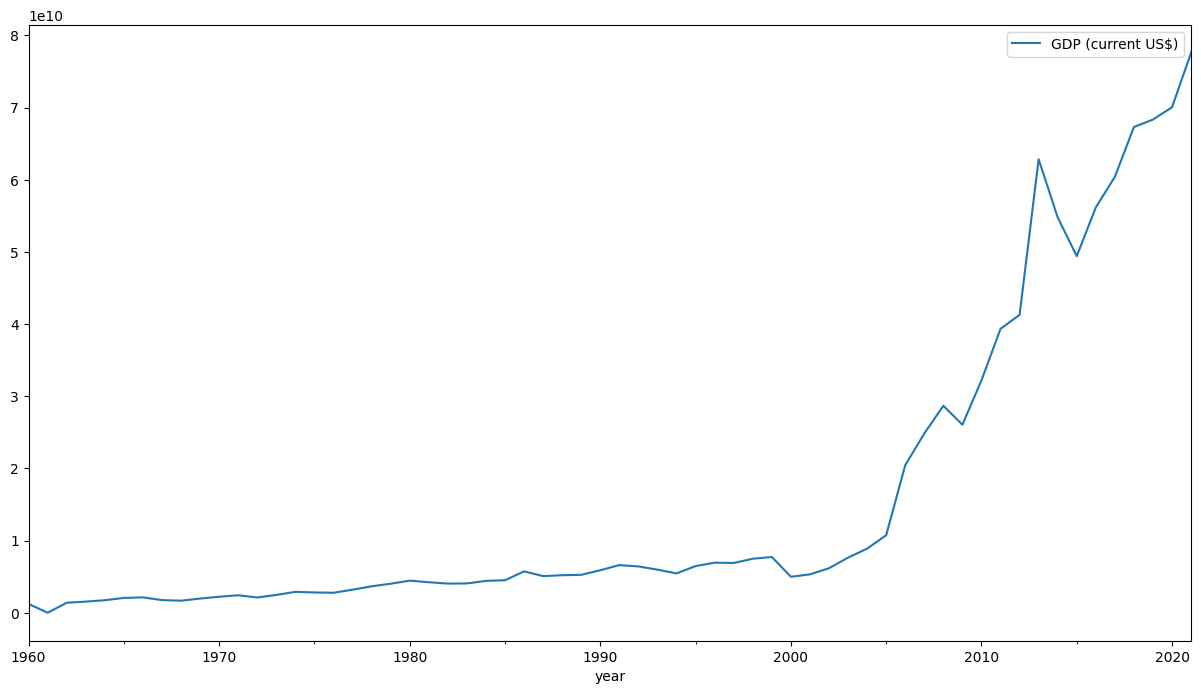

In [44]:
# Визуализируем исходный временной ряд

import matplotlib.pyplot as plt
%matplotlib inline

data.plot(figsize=(15,8));

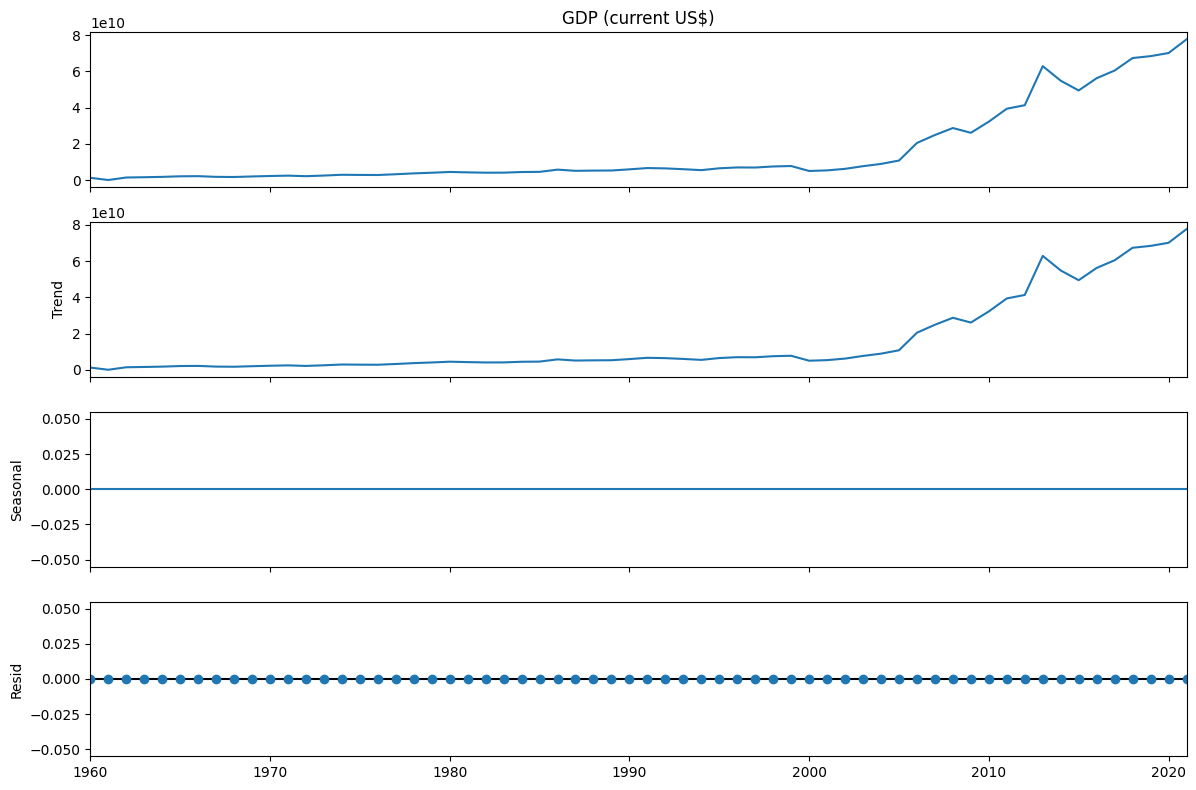

In [45]:
# Произведем декомпозицию временного ряда

from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(data['GDP (current US$)'])
plt.rcParams["figure.figsize"] = 12,8
result.plot()
plt.show()

In [46]:
# Откладываем train и test

train_data = data.iloc[:-3]
test_data = data.iloc[-3:]

train_data.shape, test_data.shape

((59, 1), (3, 1))

#### Вывод:
##### Сезонной и шумовой компоненты не выявлено. Тренд показывает тенденцию к росту примерно c 2005 года.

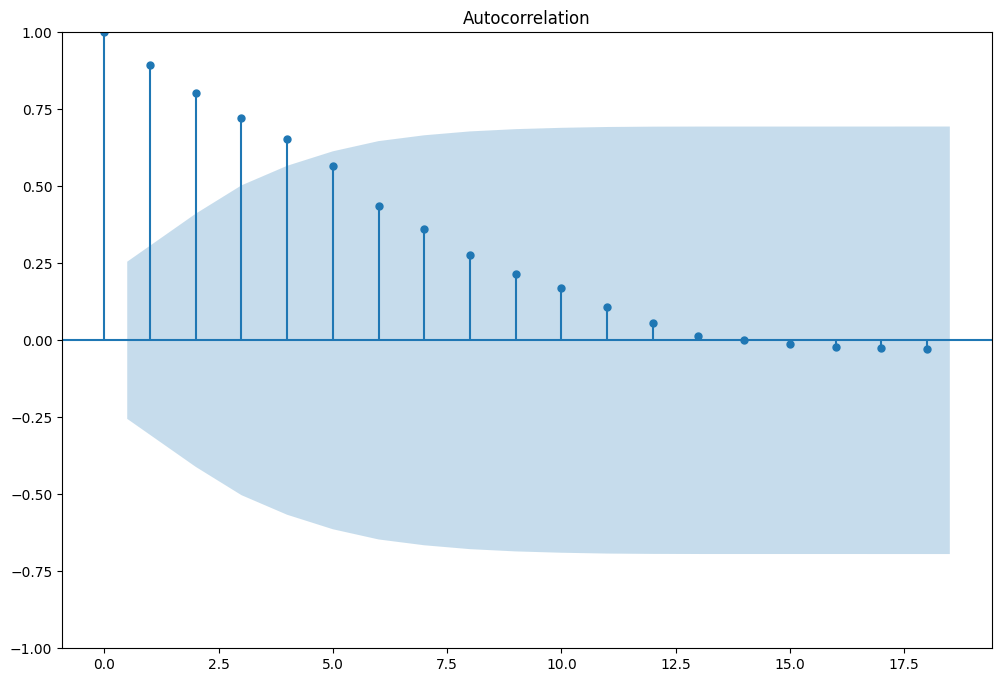

In [47]:
# Построим график автокорреляции, чтобы определить размер окна (q) для скользящего среднего 

from statsmodels.graphics.tsaplots import plot_acf
plot_acf(train_data['GDP (current US$)']);

*Максимальное значение соответстветвует q = 1, т.к. ряд содержит только тренд. Ближайшие крупные значения q равны 2, 3 и 4*

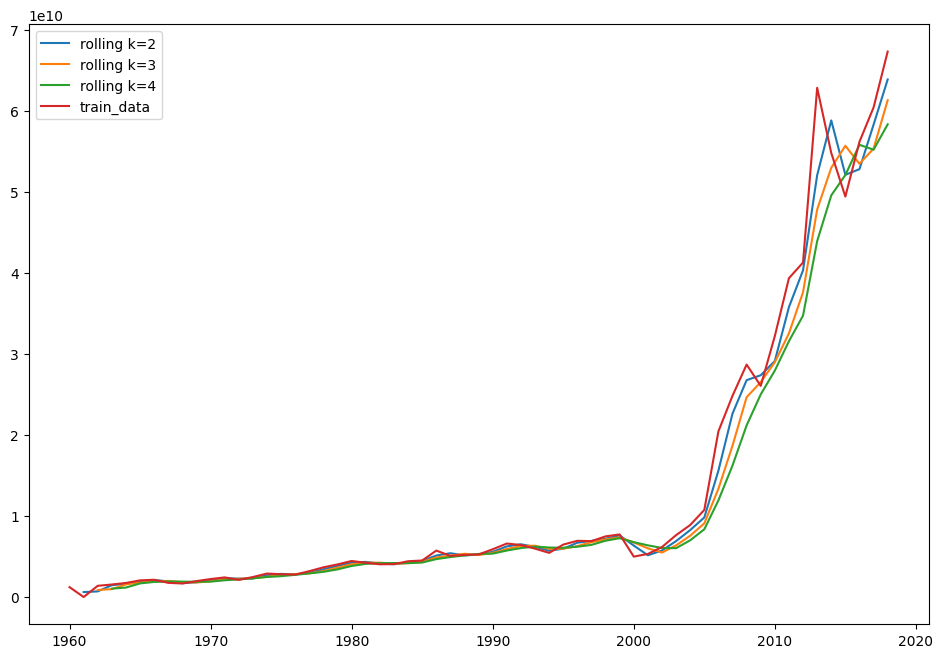

In [48]:
# Построим график скользящего среднего для q=2, q=3, q=4

fig = plt.figure(figsize=(9, 6))
axes = fig.add_axes([0, 0, 1, 1])

for i in [2, 3, 4]:
    axes.plot(train_data['GDP (current US$)'].rolling(window=i).mean(), label=f'rolling k={i}')  

axes.plot(train_data, label='train_data')
axes.legend();

#### Вывод:
При построении скользящего среднего с размерами окон q=2, q=3 и q=4 достигается определённая степень сглаживания, но т.к. сезонной компоненты нет, то этот факт слабо помогает дальнейшему прогнозированию. Тренд графика виден и без сглаживания.

In [49]:
# Проведем тест Дики_Фулера для проверки на стационарность

from statsmodels.tsa.stattools import adfuller

test = adfuller(train_data['GDP (current US$)'])
print("adf: ", test[0])
print("p-value: ", test[1])
print("Critical values: ", test[4])
if test[0] > test[4]["5%"]:
    print("ряд нестационарен")
else:
    print("ряд стационарен")

adf:  0.6529066974885364
p-value:  0.9888496277665572
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
ряд нестационарен


*Статистика теста больше всех критических значений, поэтому нулевую гипотезу ($H_0$) нельзя отвергнуть.*

*Следовательно, ряд не стационарен и будем применять модель ARIMA.*

In [50]:
# С помощью функции определим значение d для модели ARIMA

def search_d(dt, start_d=1, end_d=4):
    d = start_d
    while d < end_d+1:
        otg_i_diff = dt.diff(periods=d).dropna()
        test = adfuller(otg_i_diff)
        if test[0]>test[4]['5%']:
            d+=1
        else:
            break
    return f'Ряд стационарен при d = {d}'

search_d(train_data['GDP (current US$)'])

'Ряд стационарен при d = 2'

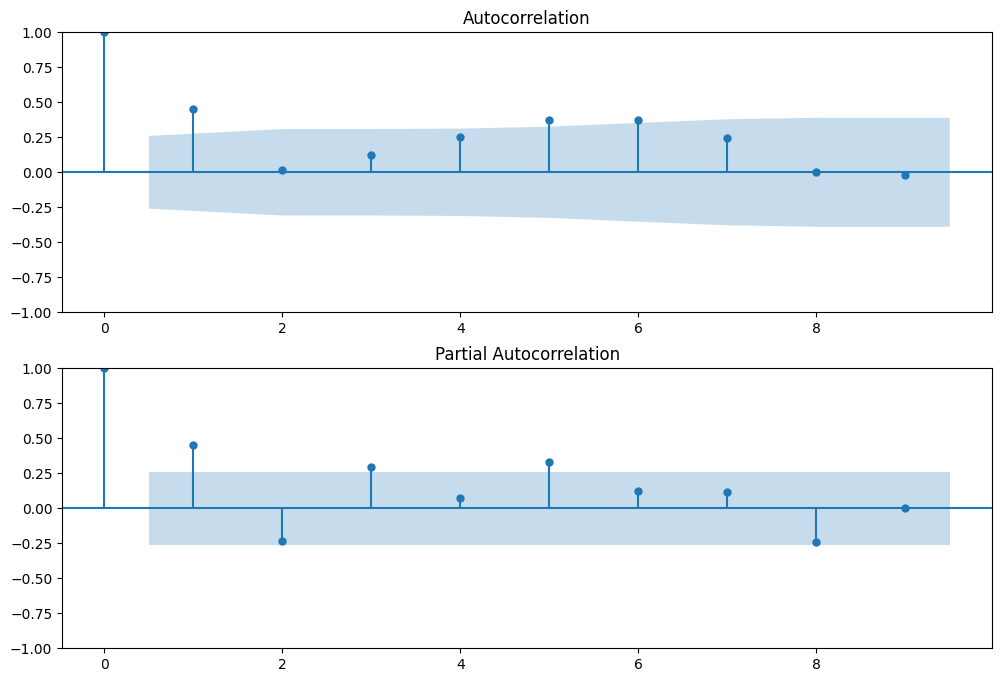

In [51]:
# Определяем параметры p и q по коррелограммам ACF и PACF для стационарного ряда.

from statsmodels.graphics.tsaplots import plot_pacf


otg_2_diff = train_data.diff(periods=2).dropna()
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(otg_2_diff.values.squeeze(), lags=9, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(otg_2_diff, lags=9, ax=ax2)

*Судя по коррелограммам q = 1 (по графику автокорреляции), p = 5 (по графику частичной автокорреляции).*

In [52]:
# Построим модель ARIMA для прогнозирования поведения временного ряда

from statsmodels.tsa.arima.model import ARIMA

arima_model = ARIMA(train_data['GDP (current US$)'].dropna(), order=(5, 2, 1))
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

c:\Users\sysadmin\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\sysadmin\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\sysadmin\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\sysadmin\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(5, 2, 1)   Log Likelihood               -1331.756
Date:                Mon, 11 Mar 2024   AIC                           2677.512
Time:                        10:54:45   BIC                           2691.813
Sample:                    01-01-1960   HQIC                          2683.070
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7719      0.374     -2.066      0.039      -1.504      -0.040
ar.L2         -0.7874      0.359     -2.192      0.028      -1.492      -0.083
ar.L3         -0.6264      0.387     -1.617      0.106      -1.385       0.133
ar.L4         -0.7573      0.314     -2.415      0.016      -1.372      -0.143
ar.L5         -0.3846      0.356     -1.079      0.281      -1.083       0.314
ma.L1         -0.3606      0.386     -0.934      0.351      -1.118       0.396
sigma2      1.285e+19   1.26e-20   1.02e+39      0.000    1.28e+19    1.28e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.16   Jarque-Bera (JB):               203.11
Prob(Q):                              0.69   Prob(JB):                         0.00
Heteroskedasticity (H):             175.02   Skew:                             1.89
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.35e+55. Standard errors may be unstable.
"""

*Критерий Акаике (AIC) равен 2677.512*

In [53]:
# Попытаемся подобрать наилучшие параметры p и q с помощью пакета `pmdarima`

import pmdarima as pm

smodel = pm.auto_arima(
    train_data['GDP (current US$)'],
    start_p=1,
    d=1,
    start_q=1,
    max_p=6,
    max_d=3,
    max_q=2,
    D=1,
    start_P=0,
    test="adf",
    error_action="ignore",
    trace=True,
)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2732.043, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2728.025, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2729.982, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2730.117, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2730.972, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.139 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   59
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1362.013
Date:                Mon, 11 Mar 2024   AIC                           2728.025
Time:                        10:54:45   BIC                           2732.146
Sample:                    01-01-1960   HQIC                          2729.631
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.139e+09   5.02e+08      2.270      0.023    1.56e+08    2.12e+09
sigma2      1.461e+19      0.176   8.28e+19      0.000    1.46e+19    1.46e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):               451.60
Prob(Q):                              0.82   Prob(JB):                         0.00
Heteroskedasticity (H):              34.65   Skew:                             2.69
Prob(H) (two-sided):                  0.00   Kurtosis:                        15.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

*Лучшее значение критерия Акаике 2728.025 при p = 0, d = 1, q = 0, найденных пакетом `pmdarima`.*

*С параметрами определенными с помощью коррелограмм (p = 5, d = 2, q = 1), критерий Акаике равен 2677.512, что ниже предыдещего, а значит лучше.*

In [54]:
# Построим модель с лучшими параметрами (p = 5, d = 2, q = 1) и выполним предсказание для тестовой выборки.

pred_data = pd.DataFrame(index=data.index)

arima_model_best = ARIMA(train_data['GDP (current US$)'].dropna(), order=(5, 2, 1))
arima_model_best_fit = arima_model_best.fit()


pred_data['model_pred'] = arima_model_best_fit.predict(
    start=test_data.index[0], end=test_data.index[-1]
)


pred_data['GDP (current US$)'] = data['GDP (current US$)']

forecast = arima_model_best_fit.get_forecast(len(test_data.index))
forecast_data = forecast.conf_int(alpha=0.05)  # Confidence level of 95%

pred_data.at[test_data.index, 'model_pred_lower'] = forecast_data['lower GDP (current US$)']
pred_data.at[test_data.index, 'model_pred_upper'] = forecast_data['upper GDP (current US$)']

c:\Users\sysadmin\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\sysadmin\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\sysadmin\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\sysadmin\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive

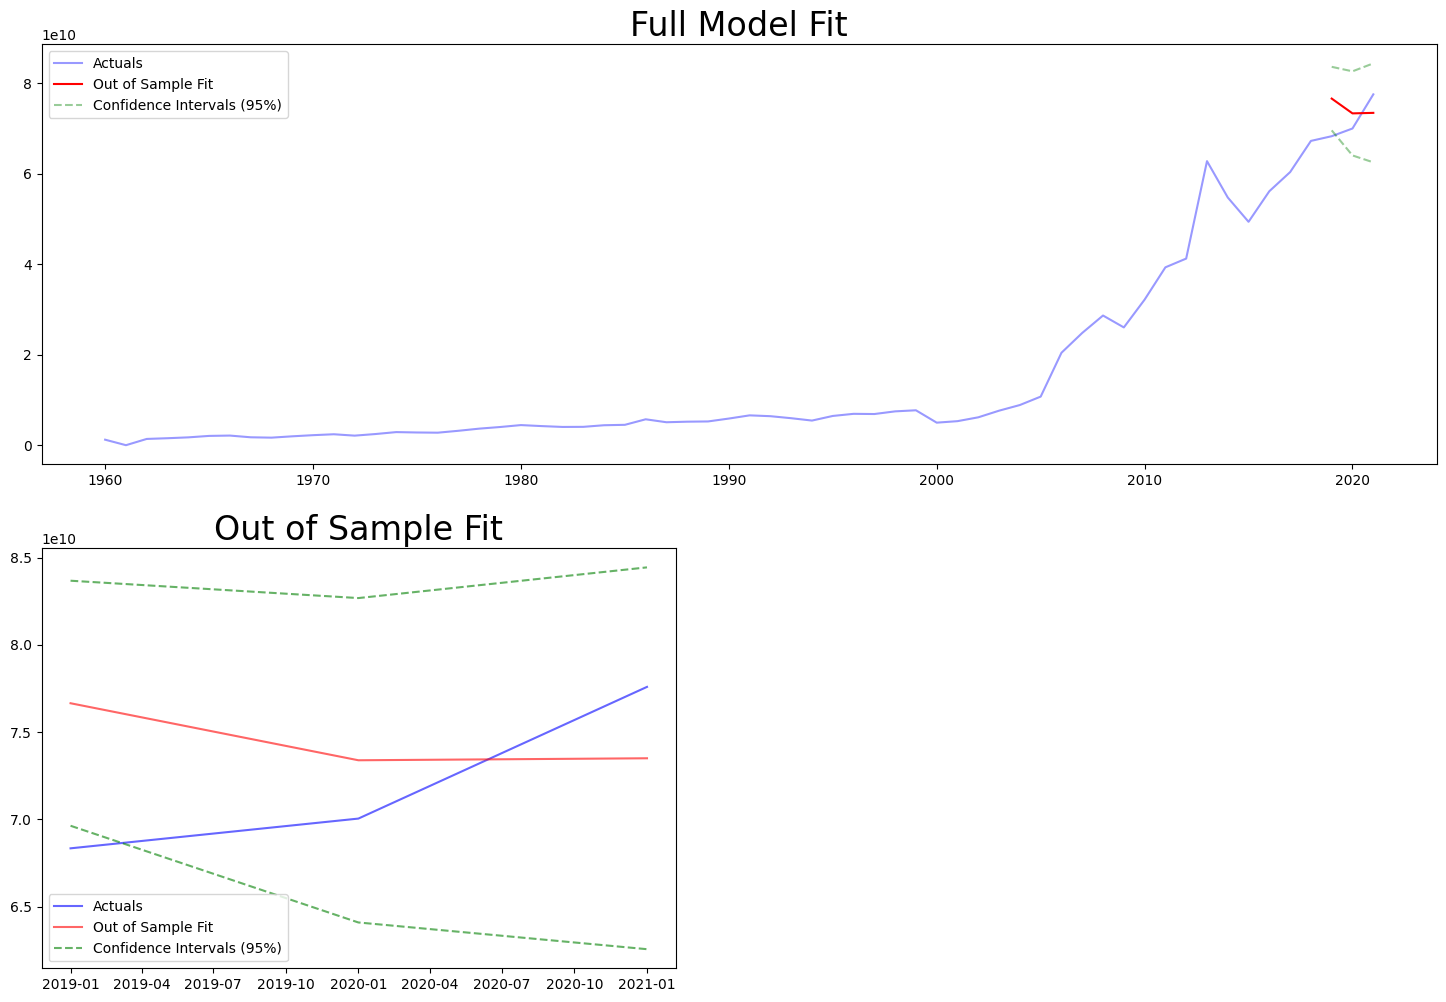

In [55]:
# Построим графики истинного и предсказанного поведения временного ряда, а также 95%-ый доверительный интервал для прогноза

plt.rcParams['figure.figsize'] = 18, 12

plt.subplot(2, 1, 1)
plt.plot(pred_data["GDP (current US$)"], color='blue', label='Actuals', alpha=0.4)

plt.plot(
    pred_data.loc[test_data.index]['model_pred'],
    color='red',
    linestyle='-',
    label='Out of Sample Fit',
)

plt.plot(
    pred_data.loc[test_data.index]['model_pred_lower'],
    color='green',
    linestyle='--',
    label='Confidence Intervals (95%)',
    alpha=0.4,
)

plt.plot(
    pred_data.loc[test_data.index]['model_pred_upper'],
    color='green',
    linestyle='--',
    alpha=0.4,
)

plt.title('Full Model Fit', size=24)
plt.legend()

plt.subplot(2, 2, 3)

plt.plot(
    pred_data.loc[test_data.index]["GDP (current US$)"], color='blue', label='Actuals', alpha=0.6
)

plt.plot(
    pred_data.loc[test_data.index]['model_pred'],
    color='red',
    linestyle='-',
    label='Out of Sample Fit',
    alpha=0.6,
)

plt.plot(
    pred_data.loc[test_data.index]['model_pred_lower'],
    color='green',
    linestyle='--',
    label='Confidence Intervals (95%)',
    alpha=0.6,
)

plt.plot(
    pred_data.loc[test_data.index]['model_pred_upper'],
    color='green',
    linestyle='--',
    alpha=0.6,
)

plt.title('Out of Sample Fit', size=24)
plt.legend()

plt.show()

In [56]:
# Рассчитаем MAPE-ошибку

from sklearn.metrics import mean_absolute_percentage_error

(mean_absolute_percentage_error(list(pred_data.loc[test_data.index]["GDP (current US$)"]),
                                 list(pred_data.loc[test_data.index]['model_pred']))*100).round()

7.0

#### Вывод:
##### Модель отработала хорошо - ошиблась на 7 % от истинного значения.

### <center><b>Интерполяция и сэмплирование.</b></center>

##### <b>ЗАДАНИЯ ДЛЯ ПРОЕКТА:</b>
1. Проверьте данные на наличие пропущенных дат. Помимо визуального способа, это можно сделать с помощью метода DataFrame.asfreq(), передав в него параметр частоты, например ‘d’ — день, ‘m’ — месяц. Все алиасы для параметров частоты доступны по [ссылке](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#timeseries-offset-aliases).

   *Подсказка ↓*
   
   *df.asfreq(freq='AS')*

2. Проверьте данные на наличие пропущенных значений (Series.isna().sum()).
3. Обратите внимание, что иногда пропуски в данных могут быть заполнены нулями. Сделайте проверку на наличие нулевых значений и в случае нахождения замените их на NaN. Воспользуйтесь кодом ниже:

   *import numpy as np*

   *df['GDP (current US$)'] = df['GDP (current US$)'].apply(lambda x: np.nan if x==0 else x)*

4. Для заполнения пропусков выполните интерполяцию с использованием метода .interpolate().

   *Подсказка ↓*
   
   *df['GDP (current US$)'].interpolate(method='linear')*

5. Проверьте полученный ряд на стационарность, определите параметры модели (ARIMA/ARMA) и запустите модель.
6. Изменился ли AIC критерий построенной модели по сравнению с моделью на неинтерполированных данных? Сделайте вывод.

In [57]:
# Проверим данные на наличие пропущенных дат

data.asfreq(freq='AS')

,GDP (current US$)
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09
...,...
2017-01-01,6.040638e+10
2018-01-01,6.729928e+10
2019-01-01,6.833754e+10


*Размерность накаяже как и исходного датасета, следовательно, пропущенных дат нет.*

In [58]:
# Проверим данные на наличие пропущенных значений

data['GDP (current US$)'].isna().sum()

0

*Явных пропусков в значениях нет.*

In [59]:
# Сделаем проверку на наличие нулевых значений и в случае нахождения заменим их на NaN

import numpy as np

data['GDP (current US$)'] = data['GDP (current US$)'].apply(lambda x: np.nan if x == 0 else x)

data['GDP (current US$)'].isna().sum()

1

In [60]:
# Имелось одно нулевое значение. Выведем его на экран.

data_nan = data.isna()
data_nan[data_nan['GDP (current US$)'] == True]

,GDP (current US$)
year,
1961-01-01,True


*Это значение за 1961 год.*

In [61]:
# Для заполнения пропусков выполним интерполяцию

interpolated_data = pd.DataFrame(data['GDP (current US$)'].interpolate(method='linear'))

In [62]:
# Откладываем train и test

train_df = interpolated_data.iloc[:-3]
test_df = interpolated_data.iloc[-3:]

train_df.shape, test_data.shape

((59, 1), (3, 1))

In [63]:
# Проверим полученный ряд на стационарность

test = adfuller(train_df['GDP (current US$)'])
print("adf: ", test[0])
print("p-value: ", test[1])
print("Critical values: ", test[4])
if test[0] > test[4]["5%"]:
    print("ряд нестационарен")
else:
    print("ряд стационарен")

adf:  0.8030073326980115
p-value:  0.9916845572455877
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
ряд нестационарен


*Статистика теста больше всех критических значений, поэтому нулевую гипотезу ($H_0$) нельзя отвергнуть.*

*Следовательно, ряд не стационарен и будем применять модель ARIMA.*

In [64]:
# Определим значение d для модели ARIMA

search_d(train_df['GDP (current US$)'])

'Ряд стационарен при d = 2'

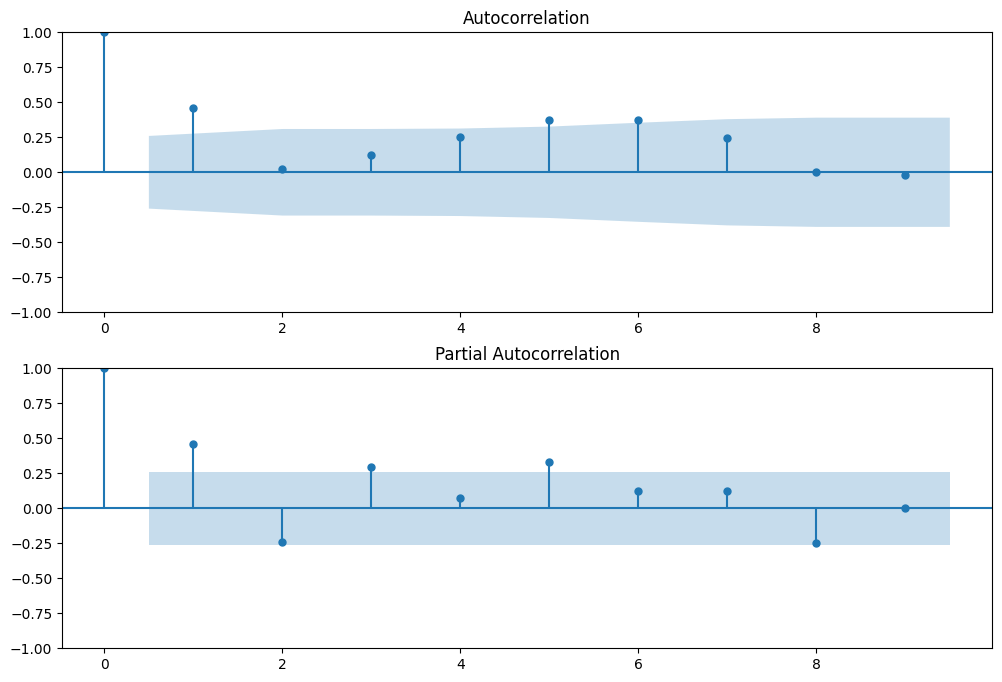

In [65]:
# Определяем параметры p и q по коррелограммам ACF и PACF для стационарного ряда.

otg_2_diff = train_df.diff(periods=2).dropna()
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(otg_2_diff.values.squeeze(), lags=9, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(otg_2_diff, lags=9, ax=ax2)

*Судя по коррелограммам q = 1 (по графику автокорреляции), p = 5 (по графику частичной автокорреляции).*

In [66]:
# Построим модель ARIMA для прогнозирования поведения временного ряда

arima_model = ARIMA(train_df['GDP (current US$)'].dropna(), order=(5, 2, 1))
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

c:\Users\sysadmin\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\sysadmin\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\sysadmin\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\sysadmin\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(5, 2, 1)   Log Likelihood               -1331.694
Date:                Mon, 11 Mar 2024   AIC                           2677.389
Time:                        10:54:49   BIC                           2691.690
Sample:                    01-01-1960   HQIC                          2682.947
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7694      0.375     -2.052      0.040      -1.504      -0.035
ar.L2         -0.7892      0.360     -2.194      0.028      -1.494      -0.084
ar.L3         -0.6258      0.389     -1.607      0.108      -1.389       0.137
ar.L4         -0.7573      0.315     -2.400      0.016      -1.376      -0.139
ar.L5         -0.3818      0.358     -1.068      0.286      -1.083       0.319
ma.L1         -0.3596      0.388     -0.926      0.354      -1.121       0.402
sigma2      1.282e+19   1.33e-20   9.64e+38      0.000    1.28e+19    1.28e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):               208.08
Prob(Q):                              0.68   Prob(JB):                         0.00
Heteroskedasticity (H):             287.04   Skew:                             1.92
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.89e+56. Standard errors may be unstable.
"""

*Критерий Акаике (AIC) равен 2677.389*

#### Вывод:
##### Показатель критерия Акаике в построенной модели незначительно изменился в лучшую сторону (на 0.123) по сравнению с моделью неинтерполированных данных. Незначительное улучшение связано с тем, что в данных был только один пропуск в начале временного ряда (за 1961 год).

### <center><b>Модели прогнозирования гетероскедастичности. Валидация временных рядов.</b></center>

##### <b>ЗАДАНИЯ ДЛЯ ПРОЕКТА:</b>
1. Посчитайте волатильность для вашего временного ряда.
2. Используйте GARCH-модель для предсказания волатильности.
3. Используйте линейную регрессию для получения прогноза.
4. Визуализируйте полученное предсказание вместе с фактическим значением.
5. Сравните результаты и сделайте выводы.
6. Почему результат модели GARCH получился именно таким?

In [67]:
# Посчитаем волатильность для нашего временого ряда

data_vol = interpolated_data.copy()

data_vol['GDP_vol'] = data_vol['GDP (current US$)'].pct_change(1).mul(100).abs()
data_vol['GDP_vol'].head()

year
1960-01-01          NaN
1961-01-01     6.789413
1962-01-01     6.357759
1963-01-01    11.448835
1964-01-01    12.363636
Name: GDP_vol, dtype: float64

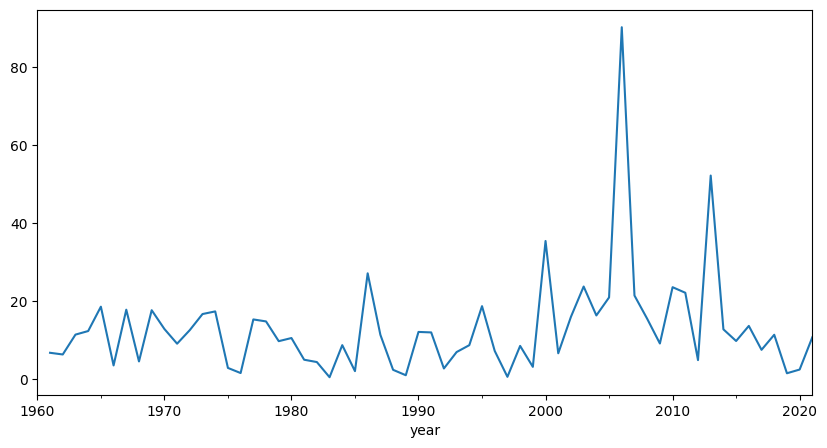

In [68]:
# Визуализируем полученный результат

plt.rcParams["figure.figsize"] = 10, 5
data_vol['GDP_vol'].plot()
plt.show()

In [69]:
# Откладываем train и test

train_dt = data_vol.iloc[:-3]
test_dt = data_vol.iloc[-3:]

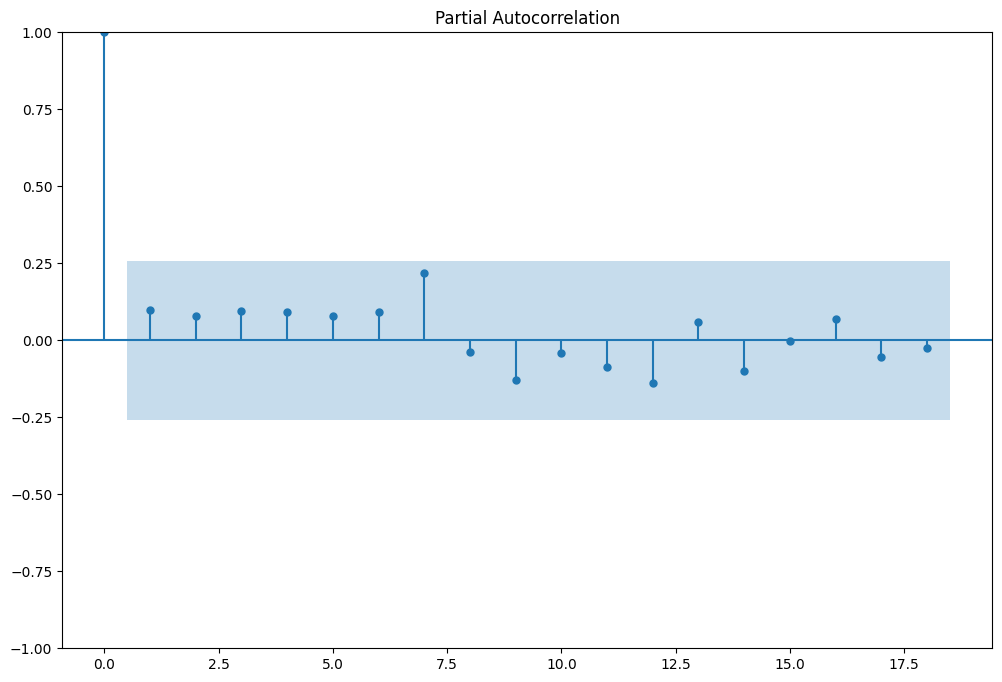

In [70]:
# Построим PACF для волатильности

plt.rcParams["figure.figsize"] = 12, 8
plot_pacf(train_dt['GDP_vol'].iloc[1:])
plt.show()

*Наиболее значимым лагом является 7, поэтому p = 7*

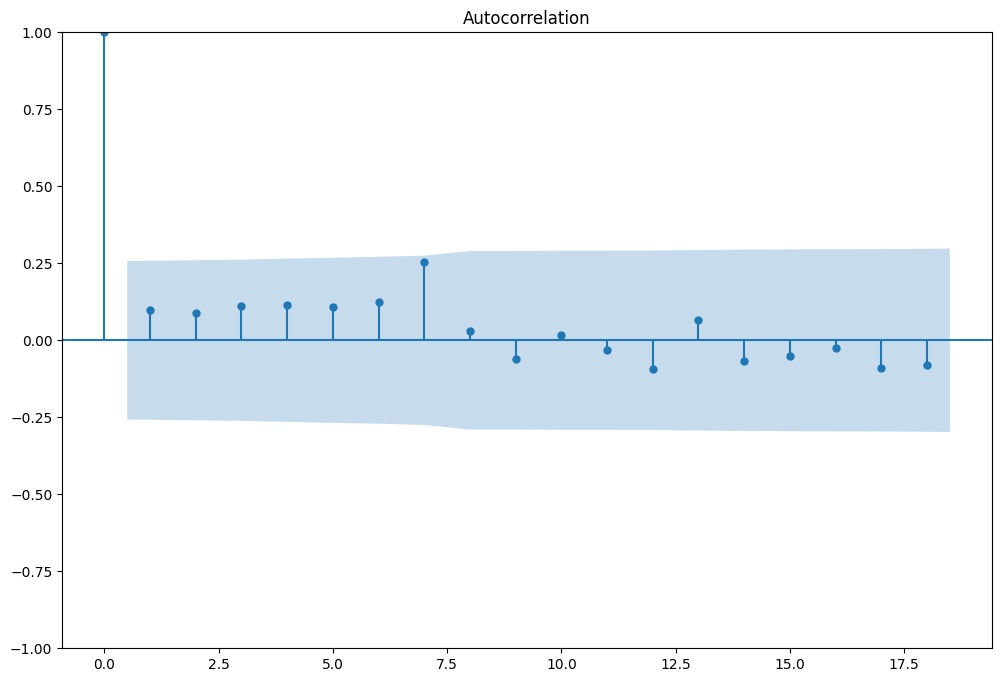

In [71]:
# Построим ACF для волатильности

plt.rcParams["figure.figsize"] = 12, 8
plot_acf(train_dt['GDP_vol'].iloc[1:])
plt.show()

*Наиболее значимым лагом является 0, поэтому q = 0*

In [72]:
#проверяем на стационарность

adfuller(train_dt.GDP_vol[1:])

(-6.725311059553779,
 3.4014596148856493e-09,
 0,
 57,
 {'1%': -3.5506699942762414,
  '5%': -2.913766394626147,
  '10%': -2.5946240473991997},
 382.739595975669)

*Значение статистики -6.7 это меньше всех p-value значит наш ряд стационарен.*

In [73]:
#!pip install arch

In [74]:
# Используем GARCH-модель для предсказания волатильности
# Нам важно сохранить объем датасета, поэтому берем за исходные данные весь датасет с индексами, который содержит
# и train и test часть

garch_dt = pd.DataFrame(data_vol["GDP_vol"].loc[data_vol.index])

# далее необходимо использовать актуальные обучающие данные, которые находятся в выборке train_df

garch_dt.loc[train_dt.index, "GDP_vol"] = train_dt["GDP_vol"].dropna()

In [75]:
from arch import arch_model

model = arch_model(garch_dt["GDP_vol"].dropna(), vol='GARCH', p=7, q=0)

# в параметре last_obs указываем последний объект, до которого будем совершать обучение.
# в нашем случае это до первого объекта из test выборки

model_results = model.fit(last_obs=test_dt.index[0], update_freq=5)

Iteration:      5,   Func. Count:     55,   Neg. LLF: 217.44764981117177
Iteration:     10,   Func. Count:    107,   Neg. LLF: 216.9744085936657
Iteration:     15,   Func. Count:    159,   Neg. LLF: 889.0900487962847
Iteration:     20,   Func. Count:    212,   Neg. LLF: 214.0078660016918
Optimization terminated successfully    (Exit mode 0)
            Current function value: 214.0074931883244
            Iterations: 23
            Function evaluations: 241
            Gradient evaluations: 23


In [76]:
model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:                GDP_vol   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -214.007
Distribution:                  Normal   AIC:                           446.015
Method:            Maximum Likelihood   BIC:                           464.559
                                        No. Observations:                   58
Date:                Mon, Mar 11 2024   Df Residuals:                       57
Time:                        10:54:51   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            11.8577      1.325      8.951  3.516e-19 [  9.261, 14.454]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega         44.2349     13.740      3.219  1.285e-03      [ 17.304, 71.165]
alpha[1]       0.0000  4.575e-02      0.000      1.000 [-8.967e-02,8.967e-02]
alpha[2]       0.0000  1.313e-02      0.000      1.000 [-2.574e-02,2.574e-02]
alpha[3]       0.0000  2.876e-02      0.000      1.000 [-5.637e-02,5.637e-02]
alpha[4]   3.5931e-03  4.736e-03      0.759      0.448 [-5.689e-03,1.287e-02]
alpha[5]       0.0000  8.569e-03      0.000      1.000 [-1.679e-02,1.679e-02]
alpha[6]       0.7330      0.486      1.509      0.131      [ -0.219,  1.685]
alpha[7]       0.1023  5.610e-02      1.824  6.818e-02   [-7.638e-03,  0.212]
=============================================================================

Covariance estimator: robust
"""

*Критерий Акаике (AIC) равен 446.015*

In [77]:
# Делаем предсказание волатильности

predictions_dt = test_dt.copy()
predictions_dt["Predictions"] = model_results.forecast().residual_variance.loc[
    test_dt.index
]

In [78]:
# Используем линейную регрессию для получения прогноза

from sklearn.linear_model import LinearRegression

X_train = pd.DataFrame(range(data_vol["GDP_vol"].shape[0]))[
    : train_dt.shape[0]
].fillna(0)
X_test = pd.DataFrame(range(data_vol["GDP_vol"].shape[0]))[
    train_dt.shape[0] :
].fillna(0)
y_train = train_dt["GDP_vol"].fillna(0)
y_test = test_dt["GDP_vol"].fillna(0)

In [79]:
# Делаем прогноз

lr = LinearRegression()
lr.fit(X_train, y_train)
lr_predict = lr.predict(X_test)

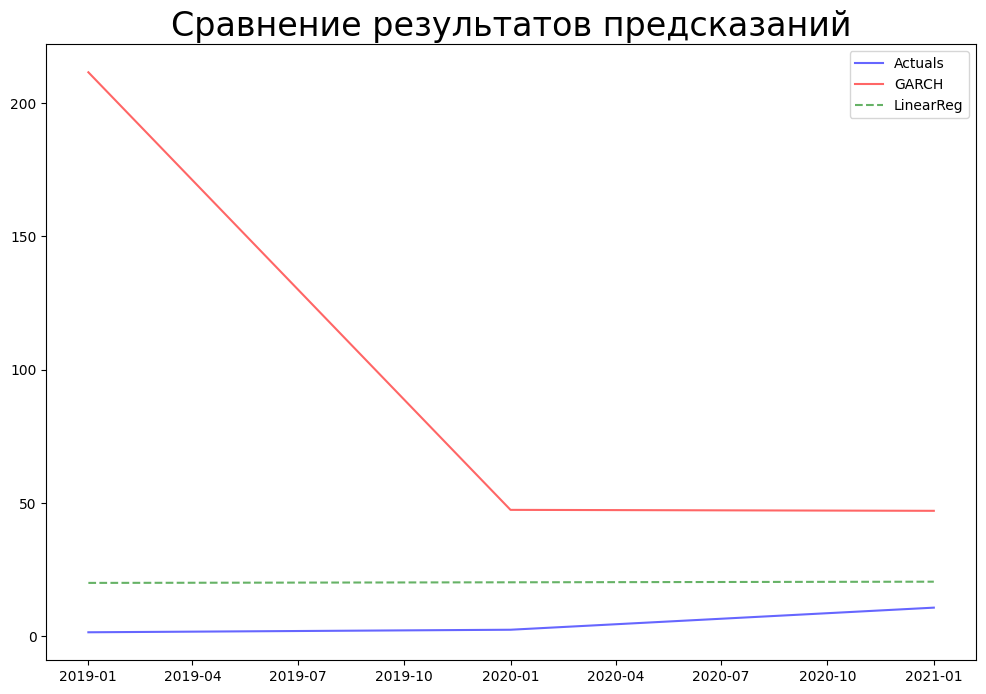

In [80]:
# Визуализируем полученные предсказания вместе с фактическим значением

plt.plot(
    data_vol.loc[test_dt.index]["GDP_vol"], color="blue", label="Actuals", alpha=0.6
)

plt.plot(
    predictions_dt.loc[test_dt.index]["Predictions"],
    color="red",
    linestyle="-",
    label="GARCH",
    alpha=0.6,
)

plt.plot(
    pd.Series(lr_predict, index=y_test.index),
    color="green",
    linestyle="--",
    label="LinearReg",
    alpha=0.6,
)

plt.title("Сравнение результатов предсказаний", size=24)
plt.legend()

plt.show()

#### Вывод:
##### Судя по графику выше, результат предсказания линейной регрессии намного ближе к фактическому значению. Модель GARCH отработала намного хуже линейной регрессиеи. Вероятно это прозошло из-за того, что пиков изменения волатильности было мало (в середине 1980, в 2000, и в начале 2010). Гетероскедатичность была, но только в некоторые короткие периоды. В остальные периоды волатильность изменялась в пределах определённого диапазона и линейная регрессия предсказала её намного лучше.

#### Почему результат модели GARCH получился именно таким?
##### Судя по полученному графику, модель не уловила дисперсию, так как такое поведение было для неё новым и подобные случаи были в небольшом количестве в обучающей выборке. 
##### В примере из скринкаста был противоположный результат, так как имелось больше данных и в обучающей выборке были случаи и возрастания, и убывания дисперсии, что удалось уловить модели.
##### Также в данных примера из скринкаста присутствовала циклическая компонента, что помогло модели учесть периоды изменения дисперсии. В данных для самостоятельной работы такого не было.